# Parsing GenBank File For Promoter Sequences

In [1]:
# setting up imports and data directories
data_dir="../data/"
gbfile=data_dir+'GCF_002163715.1_ASM216371v1_genomic.gbff'

In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import pandas as pd

In [3]:
'''parse_genbank_file_for_utr

    This function parses a given GenBank file and extracts all UTR regions that do not face each other.
    It creates a comprehensive output: feature_dict, records, target_promotor_seqs, ordered_keys, seqs
    The feature_dict is a dictionary of all features in the GenBank file labelled as gene, it saves the position
    and the strand as well as the sequence itself. Records inherits the GenBank records within the GenBank file.
    Target_promoter_seqs inherits the sequences with UTRs and their corresponding positions on the genome.
    Ordered_keys is a list of keys for the feature_dict dictionary that is ordered (meaning this list preserves the
    occurence of sequences within the genome of the GenBank file) and seqs is a dictionary with sequences of the UTRs
    in the direction on which they occure within the DNA sequence of the GenBank file.
    
    :param gbfile
        :type str
    :param basepairs
        :type int
    :param end_basepairs
        :type int
    :param start_basepairs
        :type int
    :param filter_facing_seqs
        :type bool
    
    :returns feature_dict, records, target_promotor_seqs, ordered_keys, seqs
        :type tuple(dict, list, dict, list, dict)

'''
def parse_genbank_file_for_utr(gbfile:str,
                               basepairs=200, 
                               end_basepairs=180,
                               start_basepairs=60, 
                               filter_facing_seqs=True)->tuple:

    records = []
    for record in SeqIO.parse(gbfile,'genbank'):
        records.append(record)

    print("[+] Working on {} genbank records".format(len(records)))
    print("[+] Extracting all sequences with location from end plus {}bp".format(basepairs))
    count = 0
    feature_dict = {}
    #list inherits all protein identifier from start to end of gb file
    ordered_keys = []
    for index, rec in enumerate(records):
        try:
            for feature in rec.features:
                count += 1
                try:
                    if feature.type == 'gene':
                        #if condition to get all sequences, even the ones without any new annotation
                        if 'old_locus_tag' in feature.qualifiers:
                            if feature.location.strand == -1:
                                seq = records[0].seq[feature.location.end.position:feature.location.end.position+basepairs].reverse_complement()
                                loc = (feature.location.end.position,feature.location.end.position+basepairs)

                            elif feature.location.strand == 1:
                                seq = records[0].seq[feature.location.start.position-basepairs:feature.location.start.position]
                                loc = (feature.location.start.position-basepairs,feature.location.start.position)
                            
                            feature_dict[feature.qualifiers['old_locus_tag'][0]] = [feature.location,loc,seq,index]
                            ordered_keys.append(feature.qualifiers['old_locus_tag'][0])


                        else:
                            if feature.location.strand == -1:
                                seq = records[0].seq[feature.location.end.position:feature.location.end.position+basepairs].reverse_complement()
                                loc = (feature.location.end.position,feature.location.end.position+basepairs)
                            elif feature.location.strand == 1:
                                seq = records[0].seq[feature.location.start.position-basepairs:feature.location.start.position]
                                loc = (feature.location.start.position-basepairs,feature.location.start.position)
                            
                            feature_dict[feature.qualifiers['locus_tag'][0]] = [feature.location,loc,seq,index]
                            ordered_keys.append(feature.qualifiers['locus_tag'][0])

                except Exception as e:
                    print("[-] ERROR: {}".format(e))
                    pass
        except Exception as e:
            print("[-] ERROR: {}".format(e))
            continue
    
    #parsing feature dict - evaluating end location + basepairs of target sequences 
    target_promotor_seqs = {}
    print("[+] Try Parsing Results For Putative Promotor Sequences")
    print("\t[+] Applied filters: sequences have to be smaller than {} and bigger than {}".format(end_basepairs,start_basepairs))
    if filter_facing_seqs is True:
        print("\t[+] Filter out end facing sequences (-1 1 | 1 -1) that might share putative promotor sequences")
    for index, key in enumerate(ordered_keys):
        #do not evaluate start and end sequences
        if index > 0 and index < len(ordered_keys)-1:
            cds = feature_dict[key]
            
            if cds[0].strand == -1:#if the strand is negative look at the next sequence 
                key_before = ordered_keys[index+1]
                start = cds[0].end.position                
                cds_before = feature_dict[key_before]
                start_next_gene = cds_before[0].start.position
        

            elif cds[0].strand == 1:#if the strand is positive look at the sequence before
                key_before = ordered_keys[index-1]
                start = cds[0].start.position
                cds_before = feature_dict[key_before]
                start_next_gene = cds_before[0].end.position
            
            #filter out sequences that "look on each other"
            if filter_facing_seqs is True:
                if((cds[0].strand == -1 and cds_before[0].strand == 1) or (cds[0].strand == 1 and cds_before[0].strand == -1)) == False:
                    if cds[0].strand == -1:
                        if(abs(start_next_gene - start) <= end_basepairs) and (abs(start_next_gene - start) >= start_basepairs) :

                            if (int(cds[0].end.position) < int(cds_before[0].start.position)):
                                print("\t[+] ",key, key_before, abs(start_next_gene - start), cds[0].strand, cds_before[0].strand)
                                target_promotor_seqs[key] = [start_next_gene, start]
                            else:
                                print("\t\t[+] unusual overlapping sequences: {} - {} - strand: {}".format(key,key_before, cds[0].strand))

                    elif cds[0].strand == 1:
                        if(abs(start_next_gene - start) <= end_basepairs) and (abs(start_next_gene - start) >= start_basepairs):
                            if(int(cds_before[0].end.position) < int(cds[0].start.position)):
                                print("\t[+] ",key, key_before, abs(start_next_gene - start), cds[0].strand, cds_before[0].strand)
                                target_promotor_seqs[key] = [start_next_gene, start]
                            else:
                                print("\t\t[+] unusual overlapping sequences: {} - {} - strand: {}".format(key,key_before, cds[0].strand))


            else:
                if cds[0].strand == -1:
                    if (abs(start_next_gene - start) <= end_basepairs) and (abs(start_next_gene - start) >= start_basepairs) :
                        if(int(cds[0].end.position) < int(cds_before[0].start.position)) :
                            print("\t[+] ",key, key_before, abs(start_next_gene - start), cds[0].strand, cds_before[0].strand)
                            target_promotor_seqs[key] = [start_next_gene, start]
                        else:
                            print("\t\t[+] unusual overlapping sequences: {} - {} - strand: {}".format(key,key_before, cds[0].strand))                                       

                elif cds[0].strand == 1:
                    if(abs(start_next_gene - start) <= end_basepairs) and (abs(start_next_gene - start) >= start_basepairs):
                        if (int(cds_before[0].end.position) < int(cds[0].start.position)):
                            print("\t[+] ",key, key_before, abs(start_next_gene - start), cds[0].strand, cds_before[0].strand)
                            target_promotor_seqs[key] = [start_next_gene, start]
                        else:
                            print("\t\t[+] unusual overlapping sequences: {} - {} - strand: {}".format(key,key_before, cds[0].strand))

                            
        targets = target_promotor_seqs.keys()
        seqs = {}
        for rec in records:
            try:
                for feature in rec.features:
                    count += 1
                    try:
                        if feature.type == 'gene':
                            if 'old_locus_tag' in feature.qualifiers:
                                if feature.qualifiers['old_locus_tag'][0] in targets:
                                    if feature.location.strand == -1:
                                        seqs[feature.qualifiers['old_locus_tag'][0]] = rec.seq[feature.location.end.position:feature.location.end.position+basepairs]
                                    else:
                                        seqs[feature.qualifiers['old_locus_tag'][0]] = rec.seq[feature.location.start.position-basepairs:feature.location.start.position]

                            else:
                                if feature.qualifiers['locus_tag'][0] in targets:
                                    if feature.location.strand == -1:
                                        seqs[feature.qualifiers['locus_tag'][0]] = rec.seq[feature.location.end.position:feature.location.end.position+basepairs]
                                    else:
                                        seqs[feature.qualifiers['locus_tag'][0]] = rec.seq[feature.location.start.position-basepairs:feature.location.start.position]

                                
                    except Exception as e:
                        print("[-] ERROR: {}".format(e))
                        pass
            except Exception as e:
                print("[-] ERROR: {}".format(e))
                continue        

            
    print("[+] DONE")
    return feature_dict, records, target_promotor_seqs, ordered_keys, seqs

In [4]:
'''extract_sequences_based_on_target_promotor_seqs_dict

    Helper function to extract the target sequences from the GenBank files.
    This function parses the results of parse_genbank_file_for_utr and returns 
    the true UTR sequences.
    
    :param feature_dict
        :type dict
    :param target_promoter_seqs
        :type dict
    :param records
        :type list
    
    :returns seqs
        :type dict

'''
def extract_sequences_based_on_target_promotor_seqs_dict(feature_dict:dict,
                                                         target_promotor_seqs:dict, 
                                                         records:list)->dict:
    seqs = {}
    
    print("[+] Trying to extract putative promotor sequences")
    for target in target_promotor_seqs.keys():
        if feature_dict[target][0].strand == 1:
            loc_cds_start = target_promotor_seqs[target][0]
            loc_cds_end = target_promotor_seqs[target][1]
            try:
                seqs[target] = records[feature_dict[target][3]].seq[loc_cds_start:loc_cds_end].__str__()
            except Exception as e:
                print("[-] ERROR: {}".format(e))
        if feature_dict[target][0].strand == -1:
            loc_cds_start = target_promotor_seqs[target][1]
            loc_cds_end = target_promotor_seqs[target][0]
            try:
                seqs[target] = records[feature_dict[target][3]].seq[loc_cds_start:loc_cds_end].reverse_complement().__str__()
            except Exception as e:
                print("[-] ERROR: {}".format(e))
    print("[+] DONE")
    return seqs

In [5]:
#19.09.2022 downloaded from NCBI refseq ftp fileserver
res = parse_genbank_file_for_utr(gbfile, end_basepairs=170, start_basepairs=60)
seqs = extract_sequences_based_on_target_promotor_seqs_dict(res[0],res[2], res[1])

[+] Working on 2 genbank records
[+] Extracting all sequences with location from end plus 200bp
[+] Try Parsing Results For Putative Promotor Sequences
	[+] Applied filters: sequences have to be smaller than 170 and bigger than 60
	[+] Filter out end facing sequences (-1 1 | 1 -1) that might share putative promotor sequences
	[+]  AEP_00006 AEP_00005 73 1 1
	[+]  AEP_00011 AEP_00012 85 -1 -1
	[+]  AEP_00016 AEP_00015 136 1 1
	[+]  AEP_00017 AEP_00016 135 1 1
	[+]  AEP_00018 AEP_00017 162 1 1
	[+]  AEP_00020 AEP_00019 131 1 1
	[+]  AEP_00031 AEP_00030 62 1 1
	[+]  AEP_00033 AEP_00032 140 1 1
	[+]  AEP_00038 AEP_00037 110 1 1
	[+]  AEP_00044 AEP_00043 100 1 1
	[+]  AEP_00048 AEP_00047 69 1 1
	[+]  AEP_00061 AEP_00062 157 -1 -1
	[+]  AEP_00066 AEP_RS00340 76 -1 -1
	[+]  AEP_00073 AEP_00072 81 1 1
	[+]  AEP_00092 AEP_00091 108 1 1
	[+]  AEP_00101 AEP_00100 125 1 1
	[+]  AEP_00104 AEP_00105 90 -1 -1
	[+]  AEP_00105 AEP_00106 107 -1 -1
	[+]  AEP_00108 AEP_00107 117 1 1
	[+]  AEP_00134 AEP_00

/home/lukas/anaconda3/lib/python3.9/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(


	[+]  AEP_00251 AEP_00250 141 1 1
	[+]  AEP_00258 AEP_00257 122 1 1
	[+]  AEP_00264 AEP_00263 84 1 1
	[+]  AEP_00270 AEP_00271 69 -1 -1
	[+]  AEP_00279 AEP_00278 108 1 1
	[+]  AEP_00286 AEP_00285 76 1 1
	[+]  AEP_00288 AEP_00289 61 -1 -1
	[+]  AEP_00297 AEP_00296 90 1 1
	[+]  AEP_00298 AEP_00297 127 1 1
	[+]  AEP_00307 AEP_00308 78 -1 -1
	[+]  AEP_00308 AEP_00309 68 -1 -1
	[+]  AEP_00310 AEP_00311 108 -1 -1
	[+]  AEP_00311 AEP_00312 129 -1 -1
	[+]  AEP_00313 AEP_00314 62 -1 -1
	[+]  AEP_00316 AEP_00317 102 -1 -1
	[+]  AEP_00328 AEP_00329 130 -1 -1
	[+]  AEP_00333 AEP_00334 78 -1 -1
	[+]  AEP_00342 AEP_RS01730 83 1 1
	[+]  AEP_00343 AEP_00342 103 1 1
	[+]  AEP_00352 AEP_00351 147 1 1
	[+]  AEP_00353 AEP_00352 64 1 1
	[+]  AEP_00358 AEP_00357 135 1 1
	[+]  AEP_00362 AEP_00363 90 -1 -1
	[+]  AEP_00376 AEP_00377 70 -1 -1
	[+]  AEP_00382 AEP_00381 104 1 1
	[+]  AEP_00388 AEP_00389 75 -1 -1
	[+]  AEP_00391 AEP_00390 63 1 1
	[+]  AEP_00394 AEP_00393 72 1 1
	[+]  AEP_00398 AEP_00399 74 -1 -1
	

	[+]  AEP_01595 AEP_01594 92 1 1
	[+]  AEP_01604 AEP_01603 62 1 1
	[+]  AEP_01607 AEP_01606 82 1 1
	[+]  AEP_01611 AEP_01612 128 -1 -1
	[+]  AEP_01612 AEP_01613 87 -1 -1
	[+]  AEP_RS08145 AEP_01628 96 -1 -1
	[+]  AEP_01632 AEP_RS08180 83 -1 -1
	[+]  AEP_01635 AEP_01634 65 1 1
	[+]  AEP_01638 AEP_01639 112 -1 -1
	[+]  AEP_01645 AEP_01644 62 1 1
	[+]  AEP_01651 AEP_01650 149 1 1
	[+]  AEP_01652 AEP_01651 71 1 1
	[+]  AEP_01653 AEP_01652 145 1 1
	[+]  AEP_01664 AEP_01665 100 -1 -1
	[+]  AEP_01666 AEP_01667 93 -1 -1
	[+]  AEP_01696 AEP_01695 122 1 1
	[+]  AEP_01698 AEP_01699 146 -1 -1
	[+]  AEP_01704 AEP_01705 164 -1 -1
	[+]  AEP_01727 AEP_RS20685 83 1 1
	[+]  AEP_01743 AEP_01742 124 1 1
	[+]  AEP_01745 AEP_01744 86 1 1
	[+]  AEP_01753 AEP_01752 121 1 1
	[+]  AEP_01754 AEP_01753 70 1 1
	[+]  AEP_01758 AEP_01757 85 1 1
	[+]  AEP_01759 AEP_01760 68 -1 -1
	[+]  AEP_01760 AEP_01761 114 -1 -1
	[+]  AEP_01761 AEP_01762 133 -1 -1
	[+]  AEP_01765 AEP_01764 60 1 1
	[+]  AEP_01769 AEP_01770 75 -1 -1

	[+]  AEP_02908 AEP_02909 152 -1 -1
	[+]  AEP_02921 AEP_02920 108 1 1
	[+]  AEP_02922 AEP_02921 80 1 1
	[+]  AEP_02927 AEP_02926 88 1 1
	[+]  AEP_02928 AEP_02929 133 -1 -1
	[+]  AEP_02933 AEP_02934 109 -1 -1
	[+]  AEP_02935 AEP_02936 66 -1 -1
	[+]  AEP_RS14695 AEP_02950 131 1 1
	[+]  AEP_02953 AEP_02952 81 1 1
	[+]  AEP_02954 AEP_02953 106 1 1
	[+]  AEP_02955 AEP_02954 84 1 1
	[+]  AEP_02959 AEP_02958 62 1 1
	[+]  AEP_02969 AEP_02968 137 1 1
	[+]  AEP_02970 AEP_02969 66 1 1
	[+]  AEP_02974 AEP_02973 147 1 1
	[+]  AEP_02980 AEP_02981 96 -1 -1
	[+]  AEP_RS14925 AEP_02992 121 -1 -1
	[+]  AEP_02994 AEP_RS14945 118 -1 -1
	[+]  AEP_RS14945 AEP_RS20750 94 -1 -1
	[+]  AEP_03007 AEP_03008 119 -1 -1
	[+]  AEP_03018 AEP_03017 166 1 1
	[+]  AEP_03019 AEP_03018 124 1 1
	[+]  AEP_03023 AEP_03022 83 1 1
	[+]  AEP_03024 AEP_03023 87 1 1
	[+]  AEP_03027 AEP_03028 101 -1 -1
	[+]  AEP_03034 AEP_03032 105 1 1
	[+]  AEP_03037 AEP_03036 70 1 1
	[+]  AEP_03043 AEP_03042 117 1 1
	[+]  AEP_03049 AEP_03050 93 -

In [48]:
seqs['AEP_03680']

KeyError: 'AEP_03680'

In [6]:
print("[+] Number of target promotor sequences: {}".format(len(res[2])))

[+] Number of target promotor sequences: 749


In [7]:
print("[+] Number of extracted sequences: {}".format(len(seqs)))

[+] Number of extracted sequences: 749


In [8]:
df_seqs=pd.DataFrame(seqs,index=['seq']).transpose()
df_seqs = df_seqs.reset_index()
df_seqs.columns=['aep','seq']
df_seqs.head()

,aep,seq
0,AEP_00006,GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAAC...
1,AEP_00011,GCATCTGCATTACCCGGCATGCATGCGCGGGCGATATTGAGGTGCC...
2,AEP_00016,ACAGATTTACGTCAATTAGTGCTCTAGCGCACATCCAGTGTGCGCG...
3,AEP_00017,TGAAGTTTTTCCTGTGTGTGCTTCGGCTGGCTCAACACACAGGGAT...
4,AEP_00018,GCAGTTGCAGGCACACCAAAAGGCCACTTCGGTGGCCTTTTGTGTT...


In [9]:
deseq2_excel=data_dir + "excel_sheet_ordered_degs_curvibacter_aep_to_wp.xlsx"
deseq2_df=pd.read_excel(deseq2_excel)
deseq2_df.head()

,Wp_Number,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,aep,protein_note
0,"WP_087493495,1",50.598761,1.899626,0.436455,4.352397,0.000013,0.000077,AEP_00001,response regulator transcription factor
1,"WP_087493496,1",22.575473,0.628642,0.481786,1.304814,0.191956,0.299217,AEP_00002,sodium-translocating pyrophosphatase
2,"WP_087493497,1",270.521213,-0.379577,0.191567,-1.981429,0.047543,0.099776,AEP_00003,inorganic diphosphatase
3,"WP_087493498,1",24.197595,-1.034087,0.490881,-2.106592,0.035153,0.077557,AEP_00004,alpha/beta fold hydrolase
4,"WP_087493499,1",36.118731,1.262573,0.447849,2.819194,0.004814,0.014655,AEP_00005,chemotaxis protein CheW


In [10]:
promotor_stength_df=deseq2_df.merge(df_seqs,on='aep')
f = lambda s: s.replace(",",".")
promotor_stength_df['Wp_Number'] = promotor_stength_df['Wp_Number'].apply(f)

In [11]:
print("[+] Number of target promoters after merging with transcriptome dataframe: {}".format(len(promotor_stength_df)))

[+] Number of target promoters after merging with transcriptome dataframe: 723


In [12]:
print("[*] Extracting sequences that do not reside in the merged dataframe ...")
print("\t[*] Those sequences are mainly composed of tRNAs or other small nucleotide sequences")
diff = [d for d in list(df_seqs.aep.values) if d not in list(promotor_stength_df.aep)] # list of sequences that have putative promotor utrs but do not reside in the transcriptome dataframe
print("\t[*] DONE")
#e.g. AEP_00144 is a tRNA

[*] Extracting sequences that do not reside in the merged dataframe ...
	[*] Those sequences are mainly composed of tRNAs or other small nucleotide sequences
	[*] DONE


In [13]:
diff

['AEP_00144',
 'AEP_00308',
 'AEP_00343',
 'AEP_RS21205',
 'AEP_00870',
 'AEP_00871',
 'AEP_00872',
 'AEP_00877',
 'AEP_00989',
 'AEP_RS21215',
 'AEP_01185',
 'AEP_01381',
 'AEP_01383',
 'AEP_01529',
 'AEP_01727',
 'AEP_01940',
 'AEP_01943',
 'AEP_01945',
 'AEP_01948',
 'AEP_02059',
 'AEP_02062',
 'AEP_02073',
 'AEP_02558',
 'AEP_03172',
 'AEP_03617',
 'AEP_03664']

In [14]:
raw_reads_path=data_dir + "raw_read_counts.csv"
raw_reads_df=pd.read_csv(raw_reads_path)
raw_reads_df.columns=["Wp_Number","G1","G2","G3","Hydra1","Hydra2","Hydra3"]
raw_reads_df.head()

,Wp_Number,G1,G2,G3,Hydra1,Hydra2,Hydra3
0,NZ_CP015698.1_cds_1008,479,596,459,3,4,5
1,NZ_CP015698.1_cds_1009,390,367,312,1,10,6
2,NZ_CP015698.1_cds_1067,178,180,162,2,2,6
3,NZ_CP015698.1_cds_1069,157,121,128,1,5,3
4,NZ_CP015698.1_cds_122,288,213,298,1,5,15


In [15]:
promotor_stength_raw_df=promotor_stength_df.merge(raw_reads_df,on="Wp_Number")
promotor_stength_raw_df['readCountMeanGSamples'] = promotor_stength_raw_df[['G1','G2','G3']].mean(axis=1)
promotor_stength_raw_df['readCountMeanNormalized'] = promotor_stength_raw_df['readCountMeanGSamples']/promotor_stength_raw_df['readCountMeanGSamples'].max()
promotor_stength_raw_df.head()

,Wp_Number,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,aep,protein_note,seq,G1,G2,G3,Hydra1,Hydra2,Hydra3,readCountMeanGSamples,readCountMeanNormalized
0,WP_087493500.1,91.807540,0.594249,0.267723,2.219643,0.026443,0.061605,AEP_00006,methyl-accepting chemotaxis protein,GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAAC...,655,762,674,4,14,25,697.000000,0.004744
1,WP_087493505.1,208.007608,-0.973455,0.235127,-4.140120,0.000035,0.000183,AEP_00011,RDD family protein,GCATCTGCATTACCCGGCATGCATGCGCGGGCGATATTGAGGTGCC...,872,833,806,24,62,59,837.000000,0.005697
2,WP_087493510.1,452.782114,-1.014490,0.298121,-3.402952,0.000667,0.002642,AEP_00016,acetolactate synthase small subunit,ACAGATTTACGTCAATTAGTGCTCTAGCGCACATCCAGTGTGCGCG...,1883,1873,1682,55,140,111,1812.666667,0.012338
3,WP_087493511.1,2406.589014,-0.294320,0.190938,-1.541440,0.123210,0.214413,AEP_00017,ketol-acid reductoisomerase,TGAAGTTTTTCCTGTGTGTGCTTCGGCTGGCTCAACACACAGGGAT...,14578,11857,13136,232,526,648,13190.333333,0.089778
4,WP_087493512.1,244.055586,-0.985040,0.279585,-3.523225,0.000426,0.001766,AEP_00018,CDP-diacylglycerol--serine O-phosphatidyltrans...,GCAGTTGCAGGCACACCAAAAGGCCACTTCGGTGGCCTTTTGTGTT...,1054,880,990,32,67,64,974.666667,0.006634


In [16]:
print("[+] Length of dataframe after merging raw read data: {}".format(len(promotor_stength_raw_df)))

[+] Length of dataframe after merging raw read data: 723


In [17]:
df_targets = promotor_stength_raw_df[['Wp_Number','aep','readCountMeanGSamples','readCountMeanNormalized','log2FoldChange','seq']]

In [18]:
df_targets.head()

,Wp_Number,aep,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq
0,WP_087493500.1,AEP_00006,697.000000,0.004744,0.594249,GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAAC...
1,WP_087493505.1,AEP_00011,837.000000,0.005697,-0.973455,GCATCTGCATTACCCGGCATGCATGCGCGGGCGATATTGAGGTGCC...
2,WP_087493510.1,AEP_00016,1812.666667,0.012338,-1.014490,ACAGATTTACGTCAATTAGTGCTCTAGCGCACATCCAGTGTGCGCG...
3,WP_087493511.1,AEP_00017,13190.333333,0.089778,-0.294320,TGAAGTTTTTCCTGTGTGTGCTTCGGCTGGCTCAACACACAGGGAT...
4,WP_087493512.1,AEP_00018,974.666667,0.006634,-0.985040,GCAGTTGCAGGCACACCAAAAGGCCACTTCGGTGGCCTTTTGTGTT...


In [19]:
df_targets.to_csv("../results/readCountsNormalizedWpToAEP.csv")

In [20]:
result_df=df_targets.copy()

# Filtering for high/low expressed genes

In [21]:
#top 400 expressed regions
high_400 = df_targets.sort_values(by='readCountMeanNormalized', ascending=False)[:400]
#smallest 100 of the remaining regions
other_seqs = df_targets.sort_values(by='readCountMeanNormalized', ascending=False)[400:]

In [22]:
high_400.head()

,Wp_Number,aep,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq
281,WP_087494950.1,AEP_01666,146921.333333,1.000000,0.698245,GAAGTTCAGGGTTGATGCCGCTTCATCAACCCTTATTCAAAAATTC...
289,WP_087495028.1,AEP_01758,74601.000000,0.507762,-0.669634,GCTGATCCGCTACTGAATTCATAGCTGGTTGCGCATATCCGATGCG...
382,WP_087495292.1,AEP_02288,48586.000000,0.330694,-1.493181,TTTTTGTTGTCTGCGACGGTGTGCCGCCCTGTTCCCGTGCGGGGCG...
675,WP_087496962.1,AEP_03945,37609.000000,0.255981,-1.089662,CCCCGGCCTGAAAAGCAACCTGGCCCCCATTGCTTCCCTCGCGCGT...
163,WP_087494375.1,AEP_01002,30464.000000,0.207349,-1.816938,GTGCGACAGCGCACAACCAGCTGACCGGATTGATCGTATTTTTTGA...


In [23]:
#creating sequence length column for the subset of the smallest 100 of remaining regions
seq_length=lambda seq: len(seq)
other_seqs['seq_length']=other_seqs['seq'].apply(seq_length)
high_400['seq_length']=high_400['seq'].apply(seq_length)

In [24]:
low_100=other_seqs.sort_values(by='seq_length',ascending=True)[:100]

In [25]:
read_level_result_df=pd.concat([high_400,low_100])

## Plotting genome location of target sequences

In [26]:
import numpy as np
import matplotlib.pyplot as plt

#values for plotting
ordered_gene_list = res[3] #ordered_dict
result_gene_list = list(result_df['aep'])
steps = 1/len(ordered_gene_list)

x_values=np.arange(1,len(ordered_gene_list)+1)*steps
y_values=np.repeat(1,len(x_values))
#print(len(x_values) == len(y_values))
x2_values=[]
for key,value in zip(ordered_gene_list,x_values):
    if key in result_gene_list:
        x2_values.append(value)
y2_values=list(np.repeat(1,len(x2_values)))
#print(len(x2_values) == 500)
#print(len(x2_values) == len(y2_values))

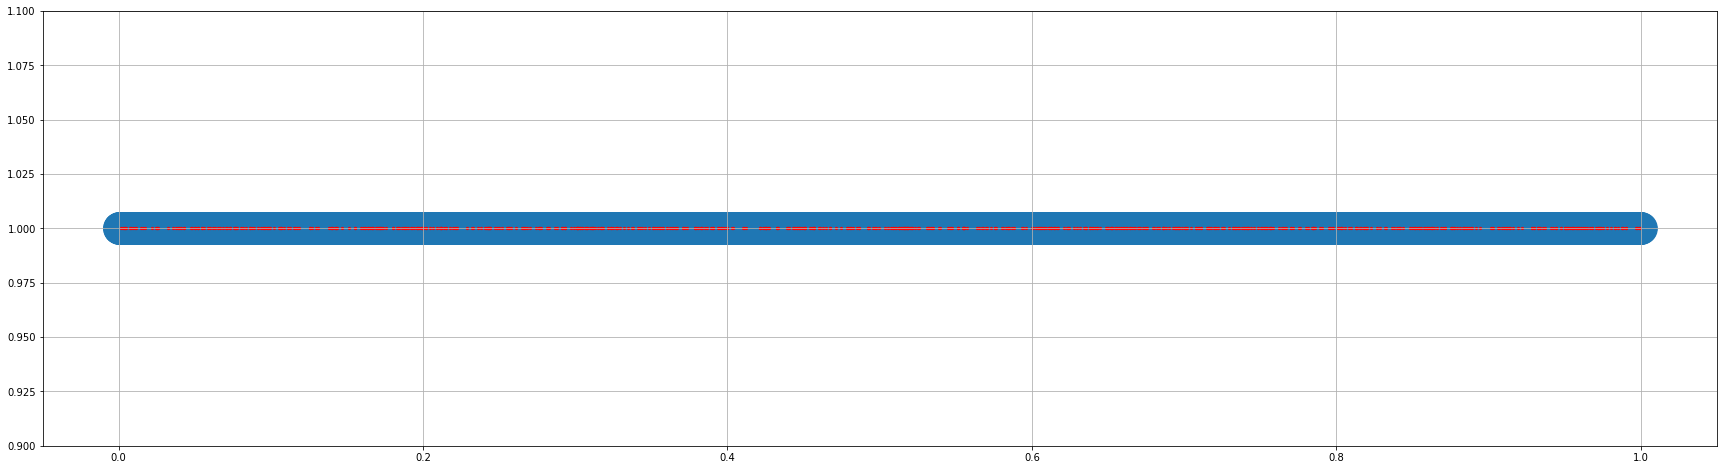

In [27]:
plt.figure(figsize=(30,8))
plt.scatter(x=x_values,y=y_values, s=1000)
plt.scatter(x=x2_values,y=y2_values, s=5, c='r')
plt.ylim(0.9,1.1)
plt.grid()

In [28]:
target_promoters = []
with open("../data/target_promoter_sequences.faa","r") as ffile:
    for line in ffile.readlines():
        if line.startswith(">"):
            target_promoters.append(line.rstrip().split(">")[1])

In [29]:
len(target_promoters)

33

# Plotting Circular Genome Plot

In [30]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [31]:
gbk = Genbank(gbfile)

In [32]:
df_500 = pd.read_excel("../data/curvibacter_first_promoter_lib.xlsx")

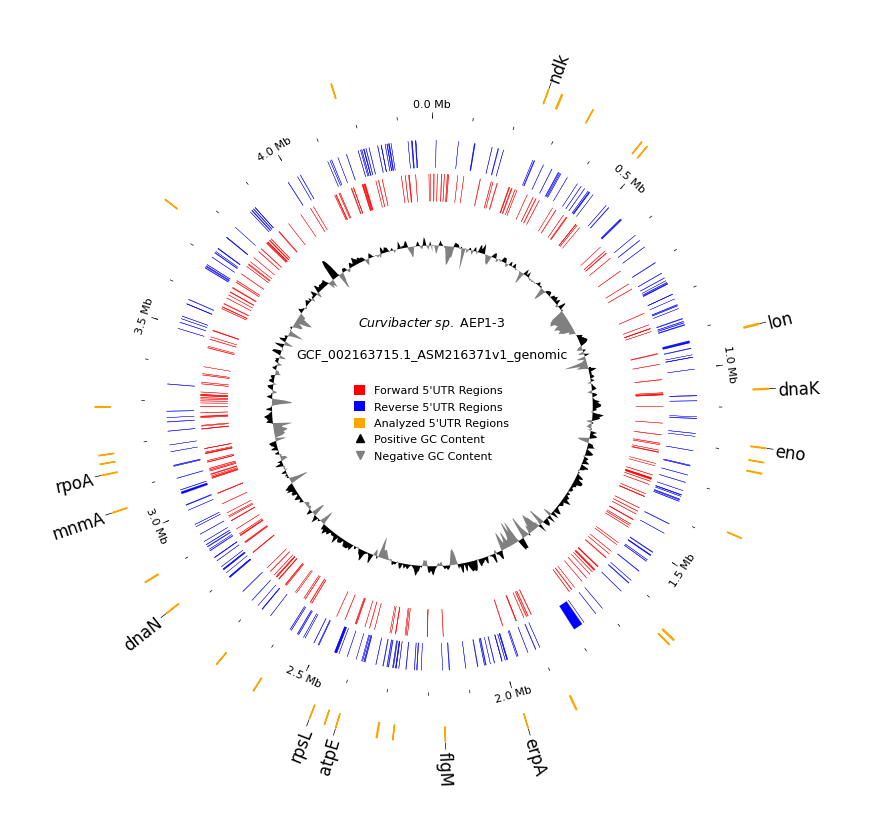

In [33]:
circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text("$\it{Curvibacter\ sp.}$ AEP1-3\n" + f"\n{gbk.name}", size=9, r=20)
sector = circos.get_sector(gbk.name)
#circos.rect(r_lim=(60, 100), fc="lightgrey", ec="none", alpha=0.5)
#sector = circos.sectors[0]

major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((80, 85))
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)
f_cds_track = sector.add_track((60, 69), r_pad_ratio=0.1)
r_cds_track = sector.add_track((70, 79), r_pad_ratio=0.1)
highlight_cds_track = sector.add_track((95,100), r_pad_ratio=0.1)

highlights = []

# extracting forward genes
f_cds_feats = gbk.extract_features("CDS", target_strand=1)

f_plot_features = []
for feature in f_cds_feats:
    if 'old_locus_tag' in feature.qualifiers.keys(): 
        if feature.qualifiers['old_locus_tag'][0] in list(df_500.name):
            f_plot_features.append(feature)
        if feature.qualifiers['old_locus_tag'][0] in target_promoters:
            highlights.append(feature)
    else:
        if feature.qualifiers['locus_tag'][0] in list(df_500.name):
            f_plot_features.append(feature)
        if feature.qualifiers['locus_tag'][0] in target_promoters:
            highlights.append(feature)

# plot forward genes
f_cds_track.genomic_features(f_plot_features, fc="red", lw=0.2, edgecolor="red")


# extracting reverse genes
r_cds_feats = gbk.extract_features("CDS", target_strand=-1)

r_plot_features = []
for feature in r_cds_feats:
    if 'old_locus_tag' in feature.qualifiers.keys(): 
        if feature.qualifiers['old_locus_tag'][0] in list(df_500.name):
            r_plot_features.append(feature)
        if feature.qualifiers['old_locus_tag'][0] in target_promoters:
            highlights.append(feature)
    else:
        if feature.qualifiers['locus_tag'][0] in list(df_500.name):
            r_plot_features.append(feature)
        if feature.qualifiers['locus_tag'][0] in target_promoters:
            highlights.append(feature)

# plot reverse genes and highlight genes
r_cds_track.genomic_features(r_plot_features, fc="blue", lw=0.2, edgecolor="blue")
highlight_cds_track.genomic_features(highlights, fc="orange", lw=1, edgecolor="orange")

# fetch labels for highlight genes
labels, label_pos_list = [], []
for feat in highlights:
    start = int(str(feat.location.start))
    end = int(str(feat.location.end))
    label_pos = (start + end) / 2
    gene_name = feat.qualifiers.get("gene", [None])[0]
    if gene_name is not None:
        labels.append(gene_name)
        label_pos_list.append(label_pos)
    #else:
        #labels.append("hyp. prot.")
        #label_pos_list.append(label_pos)
        
highlight_cds_track.xticks(label_pos_list, labels, label_size=12, label_orientation="vertical")
## Plot xticks (interval = 10 Kb)
#highlight_cds_track.xticks_by_interval(
#    10000, outer=False, label_formatter=lambda v: f"{v/1000:.1f} Kb"
#)

# plot gc content
gc_content_track = sector.add_track((40, 55))

pos_list, gc_contents = gbk.calc_gc_content()
gc_contents = gc_contents - gbk.calc_genome_gc_content()
positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
abs_max_gc_content = np.max(np.abs(gc_contents))
vmin, vmax = -abs_max_gc_content, abs_max_gc_content
gc_content_track.fill_between(
    pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
)
gc_content_track.fill_between(
    pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
)


fig = circos.plotfig()

# Add legend
handles = [
    Patch(color="red", label="Forward 5'UTR Regions"),
    Patch(color="blue", label="Reverse 5'UTR Regions"),
    Patch(color="orange", label="Analyzed 5'UTR Regions"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None")
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)

plt.savefig("../results/circos_curvibacter_genome.png", dpi=400)

# Trimming Length Of Sequences

In [34]:
#import the list of promoter sequences in 5' to 3' direction in a list
raw_library = list(result_df['seq'])

# determine maximum length of promoter site to be used for expression and the maximum size of oligos to order
promoter_max_len = 98
synthesis_maxlen = 150
# determine sequences for cloning to be attached to the promoters
# designed in snapgene by maurice mager
upstream_cloningsite = "tcgagtacgacttcggtctcaGGAGc"
downstream_cloningsite = "cAATGtgagaccgaacgtcagtgatc"

# random sequence to fill synthesis order, will be cut during cloning and has no impact on construct
# filling of random nucleotides behind cloning sites if sequence too small e.g. < 98
fillup = "ATCGATCGCTAGCTAGCTAGCATCGACTATCGTCGATCGATCGATGCATGCATCTGTACGATCGACTAGCTAGTCGACTATCGACTGACTGACTGACTG"

aep_seq={}
for aep,seq in zip(result_df['aep'],result_df['seq']):
    #save the original sequence to get raw_library.index in the end
    rawstring = seq
    # cut off first base to match final RBS distance in construct - why?
    seq = seq[:-1]
    # trimming too long promoters
    if len(seq) > promoter_max_len:
        print("[+] Trimming sequence: {} with length: {}".format(aep,len(seq)))
        overlength = len(seq) - promoter_max_len
        seq = seq[overlength:]
        
    # adding cloning sites to both ends
    seq = upstream_cloningsite + seq
    seq += downstream_cloningsite
    
    #fill up synthesis for order of equal length oligos
    seq = fillup + seq
    overlength_syn = len(seq) - synthesis_maxlen
    seq = seq[overlength_syn:]

    aep_seq[aep]=seq


# checks if size of the list, size of each oligo is correct
for aep in aep_seq.keys():
    if len(aep_seq[aep]) == synthesis_maxlen:
        print("[+] {}".format(aep))
        print("\t[+] length:" + str(len(aep_seq[aep])))
    else:
        print("[-] ERROR: oligo for {} has not the correct length".format(aep))
if len(aep_seq.keys()) == len(raw_library):
    print("[+] size of order is equal to library")
else:
    print("[-] ERROR: size of order doesnt match original library")

[+] Trimming sequence: AEP_00016 with length: 135
[+] Trimming sequence: AEP_00017 with length: 134
[+] Trimming sequence: AEP_00018 with length: 161
[+] Trimming sequence: AEP_00020 with length: 130
[+] Trimming sequence: AEP_00033 with length: 139
[+] Trimming sequence: AEP_00038 with length: 109
[+] Trimming sequence: AEP_00044 with length: 99
[+] Trimming sequence: AEP_00061 with length: 156
[+] Trimming sequence: AEP_00092 with length: 107
[+] Trimming sequence: AEP_00101 with length: 124
[+] Trimming sequence: AEP_00105 with length: 106
[+] Trimming sequence: AEP_00108 with length: 116
[+] Trimming sequence: AEP_00176 with length: 104
[+] Trimming sequence: AEP_00177 with length: 116
[+] Trimming sequence: AEP_00194 with length: 156
[+] Trimming sequence: AEP_00197 with length: 154
[+] Trimming sequence: AEP_00205 with length: 139
[+] Trimming sequence: AEP_00212 with length: 107
[+] Trimming sequence: AEP_00223 with length: 115
[+] Trimming sequence: AEP_00239 with length: 99
[+

In [35]:
trimmed_seqs_df=pd.DataFrame(aep_seq, index=['seq']).transpose()
trimmed_seqs_df = trimmed_seqs_df.reset_index()
trimmed_seqs_df.columns=['aep','trimmed_seq']
trimmed_seqs_df.head()

,aep,trimmed_seq
0,AEP_00006,TCGACTATCGACTGACTGACTGACTGtcgagtacgacttcggtctc...
1,AEP_00011,TGACTGACTGACTGtcgagtacgacttcggtctcaGGAGcGCATCT...
2,AEP_00016,tcgagtacgacttcggtctcaGGAGcGTGTGCGCGAGCTGCTATCA...
3,AEP_00017,tcgagtacgacttcggtctcaGGAGcACACAGGGATTGTTTGGCGA...
4,AEP_00018,tcgagtacgacttcggtctcaGGAGcAGGGCTTCATTGCACTGCTT...


In [36]:
result_df=result_df.merge(trimmed_seqs_df,on='aep')

In [37]:
result_df.head()

,Wp_Number,aep,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq,trimmed_seq
0,WP_087493500.1,AEP_00006,697.000000,0.004744,0.594249,GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAAC...,TCGACTATCGACTGACTGACTGACTGtcgagtacgacttcggtctc...
1,WP_087493505.1,AEP_00011,837.000000,0.005697,-0.973455,GCATCTGCATTACCCGGCATGCATGCGCGGGCGATATTGAGGTGCC...,TGACTGACTGACTGtcgagtacgacttcggtctcaGGAGcGCATCT...
2,WP_087493510.1,AEP_00016,1812.666667,0.012338,-1.014490,ACAGATTTACGTCAATTAGTGCTCTAGCGCACATCCAGTGTGCGCG...,tcgagtacgacttcggtctcaGGAGcGTGTGCGCGAGCTGCTATCA...
3,WP_087493511.1,AEP_00017,13190.333333,0.089778,-0.294320,TGAAGTTTTTCCTGTGTGTGCTTCGGCTGGCTCAACACACAGGGAT...,tcgagtacgacttcggtctcaGGAGcACACAGGGATTGTTTGGCGA...
4,WP_087493512.1,AEP_00018,974.666667,0.006634,-0.985040,GCAGTTGCAGGCACACCAAAAGGCCACTTCGGTGGCCTTTTGTGTT...,tcgagtacgacttcggtctcaGGAGcAGGGCTTCATTGCACTGCTT...


## Checking Trimming Procedure

In [38]:
pContent = lambda cont:print(str(cont))

In [39]:
result_df[result_df['aep'] == 'AEP_00006']['seq'].apply(pContent)

GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAACAGTATTTAACTTTTGTTGGAGTAGACG


0    None
Name: seq, dtype: object

In [40]:
result_df[result_df['aep'] == 'AEP_00006']['trimmed_seq'].apply(pContent)

TCGACTATCGACTGACTGACTGACTGtcgagtacgacttcggtctcaGGAGcGGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAACAGTATTTAACTTTTGTTGGAGTAGACcAATGtgagaccgaacgtcagtgatc


0    None
Name: trimmed_seq, dtype: object

## Filtering for restriction sites

In [41]:
# restriction size filtering:
bbs1="GAAGAC"
bsmb1="CGTCTC"
bsa1="GGTCTC"

In [42]:
filtered=[]
for aep,seq in zip(result_df['aep'],result_df['seq']):
    if bsa1 in str(seq):
        filtered.append(aep)
        print("[+] Found BSA1 Restriction site: {} in {}".format(bsa1,aep))
        idx=result_df[result_df['aep'] == aep].index.to_list()
        if len(idx) > 1:
            raise Exception("[-] Multiple rows for one target")
        else:
            idx=idx[0]
            print("[+] Removing row {} from dataframe".format(idx))
            result_df=result_df.drop(idx)#deletion of sequences with BSA1 restriction sites
    if bbs1 in str(seq):
        print("\t[+] Found BBS1 Restriction site: {} in {}".format(bbs1,aep))
    if bsmb1 in str(seq):
        print("\t[+] Found BSMB1 Restriction site: {} in {}".format(bsmb1,aep))
print("[-] Number of promotors with restriction sites: {}".format(len(filtered)))

	[+] Found BBS1 Restriction site: GAAGAC in AEP_00194
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_00212
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_00239
[+] Found BSA1 Restriction site: GGTCTC in AEP_00707
[+] Removing row 111 from dataframe
	[+] Found BBS1 Restriction site: GAAGAC in AEP_00742
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_00821
	[+] Found BBS1 Restriction site: GAAGAC in AEP_01203
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_01406
[+] Found BSA1 Restriction site: GGTCTC in AEP_01825
[+] Removing row 300 from dataframe
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_01891
[+] Found BSA1 Restriction site: GGTCTC in AEP_01892
[+] Removing row 318 from dataframe
[+] Found BSA1 Restriction site: GGTCTC in AEP_01936
[+] Removing row 325 from dataframe
	[+] Found BSMB1 Restriction site: CGTCTC in AEP_02735
[+] Found BSA1 Restriction site: GGTCTC in AEP_02748
[+] Removing row 465 from dataframe
	[+] Found BBS1 Restriction site: GAAGAC in AEP_03023
	[+] Foun

In [43]:
print("[+] length of final dataframe: {}".format(len(result_df)))

[+] length of final dataframe: 715


In [44]:
data_dir_excel=data_dir + "target_promotors.xlsx"
result_df.to_excel(data_dir_excel)

In [45]:
additional_promotor_seqs=["AEP_03486","AEP_03466","AEP_03465","AEP_03459","AEP_02900"]